In [1]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import os 
from glob import glob 
import numpy as np 

In [2]:
kernel = np.array([[-1,-1,-1,-1,-1],
                                 [-1,2,2,2,-1],
                                 [-1,2,8,2,-1],
                                 [-1,2,2,2,-1],
                                 [-1,-1,-1,-1,-1]]) / 8.0

timebetweenframes = 30
#Parameters#
s = 1 # Scaling factor tif
jpegmax = 255 # max value for jpeg masks

In [3]:
files_tifrfp = []
files_tifgfp = []


tif_dirrfp = './rfp' 
tif_dirgfp = './gfp' 
pattern_tif = "*.tif" 
correction_dir = './corrections'

for dir,_,_ in os.walk(tif_dirrfp):
    files_tifrfp.extend(glob(os.path.join(dir,pattern_tif)))

for dir,_,_ in os.walk(tif_dirgfp):
    files_tifgfp.extend(glob(os.path.join(dir,pattern_tif)))


files_tifrfp.sort()

files_tifgfp.sort()



if len(files_tifgfp) == 0:
    GFPimages = False
else: 
    GFPimages = True
    


print(str(len(files_tifrfp)) + ' RFP images found')
print(str(len(files_tifgfp)) + ' GFP images found')

3 RFP images found
0 GFP images found


In [4]:
AVG_Dark   = cv2.imread('./corrections/AVG_Dark.tif',2 | 4)
AVG_TotalGREEN = cv2.imread('./corrections/AVG_TotalGreen.tif',2 | 4)
AVG_TotalRED = cv2.imread('./corrections/AVG_TotalRED.tif',2 | 4)


if not os.path.exists('./correctedrfptif/'):
    os.makedirs('./correctedrfptif/')
if not os.path.exists('./jpegformask/'):
    os.makedirs('./jpegformask/')
if (GFPimages):
    if not os.path.exists('./correctedgfptif/'):
        os.makedirs('./correctedgfptif/')
            
#------------------------------------------------- 
for i in range(0,len(files_tifrfp)):
    file = files_tifrfp[i]
    img = cv2.imread(file, 2 | 4)
    correctedimg = np.zeros_like(img)
    correctedimgjpg = np.zeros_like(img)
        
    # Applying FFC to RFP Images
    maxi = np.mean(AVG_TotalRED)
    for l in range (len(img)):
        for m in range (len(img[0])):
            if (img[l][m] > AVG_Dark[l][m]):
                tmp = maxi * (img[l][m] - AVG_Dark[l][m]) / (AVG_TotalRED[l][m])
                correctedimg[l][m]= s*tmp 
        
    c = np.max(correctedimg)
    background = 2 * np.mean(correctedimg)
    maxthreshold = 0.5 * c 
    for l in range (len(img)):
        for m in range (len(img[0])):
            if(0.5 * c > maxthreshold): 
                if(correctedimg[l][m] > maxthreshold):
                    correctedimgjpg[l][m] = jpegmax
                elif(correctedimg[l][m] < background): 
                    correctedimgjpg[l][m] = 0
                else:
                    correctedimgjpg[l][m] = jpegmax * ((correctedimg[l][m] - background) / (maxthreshold-background))   
            else:                
                if(correctedimg[l][m] > 0.5*c):
                    correctedimgjpg[l][m]=jpegmax
                elif(correctedimg[l][m] < background):    
                    correctedimgjpg[l][m]=0
                else:
                    correctedimgjpg[l][m]=jpegmax * ((correctedimg[l][m]-background) / (0.5*c-background))    
    cv2.imwrite("./correctedrfptif/"  + '/' + str(10000 + i) + ".tif", correctedimg)
    cv2.imwrite("./jpegformask/"  + '/'+str(10000 + i) + ".jpg", correctedimgjpg)
            
    if (GFPimages):
        for i in range(0,len(files_tifgfp)):
            if (int((i * 100) / len(files_tifgfp)) % 5 == 0):
                print(str(int(((i * 100) / len(files_tifgfp)))) + "% GFP DONE",end=',')
            file = files_tifgfp[i]
            img2 = cv2.imread(file,2 | 4)
            correctedimg = np.zeros_like(img2)
            correctedimgjpg = np.zeros_like(img2)
            maxim=np.max(AVG_TotalGREEN)
            for l in range (len(img2)):
                for m in range (len(img2[0])):
                    if (img2[l][m] > AVG_Dark[l][m]):
                        tmp=maxim * (img2[l][m] - AVG_Dark[l][m]) / (AVG_TotalGREEN[l][m])
                        correctedimg[l][m]=1 * tmp
            cv2.imwrite("./correctedgfptif/"  + '/' + str(10000+i) + ".tif", correctedimg)
    print('Image '+ str(i) + ' done') 

Image 0 done
Image 1 done
Image 2 done


In [5]:
mask_dir = './jpegformask'
red_dir = './correctedrfptif'
green_dir = './correctedgfptif'

files_mask = [] 
pattern_mask   = "*.jpg"

files_red = [] 
pattern_red   = "*.tif"

files_green = [] 
pattern_green   = "*.tif"


for dir,_,_ in os.walk(mask_dir):
    files_mask.extend(glob(os.path.join(dir,pattern_mask)))

for dir,_,_ in os.walk(red_dir):
    files_red.extend(glob(os.path.join(dir,pattern_red)))
    
for dir,_,_ in os.walk(green_dir):
    files_green.extend(glob(os.path.join(dir,pattern_green)))
    
position_names =  [x[1] for x in os.walk(red_dir)][0]

files_mask.sort()
files_red.sort()
files_green.sort()




print(str(len(files_mask)) + ' images for segmentation found.')
print(str(len(files_red)) + ' RFP images found.')
print(str(len(files_green)) + ' GFP images found.')

3 images for segmentation found.
3 RFP images found.
0 GFP images found.


In [6]:
camerapsize = 6.45
binning = 2
cMount = 0.7
objMag = 100
lensMag = 1
pixelsize = camerapsize*binning/(cMount*objMag*lensMag)
threshold = 190

In [7]:
fulllen = []
fullwid = []
fullasp = []
fullare = []
fullintR = []
fulltime = []
if(GFPimages):
    fullintG = []
    allmeanG = []
    allintG = []
    allcvG = []
imcontours = []
for i in range(0,len(files_red)):   

    img = cv2.imread(files_mask[i], 1)
    img3 = cv2.imread(files_red[i], 2 | 4)
    intR = []
    if(GFPimages):
        img2 = cv2.imread(files_green[i], 2 | 4)
        intG = [] 
    equ = cv2.filter2D(img, -1, kernel)
    gray = cv2.cvtColor(equ,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray,threshold,255,0)
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

    length = []
    wid = []
    asp = []
    are = []
    intR = []
    time = []
    
    for cnt in range(len(contours)):
        listintR = []
        if(GFPimages):
            listintG = []
        aimg = np.zeros_like(img)
        cv2.drawContours(aimg, contours, cnt, (0,0,255), thickness= -1)
        pts = np.where(aimg != 0)
        listintR.append(img3[pts[0], pts[1]])                
        r = 0
        r = np.mean(listintR[0])
        intR.append(r)
        
        if(GFPimages):
            pts = np.where(aimg != 0)
            listintG.append(img2[pts[0], pts[1]])                
            G = 0
            G = np.mean(listintG[0])
            intG.append(G)            
   
        x,y,w,h = cv2.boundingRect(contours[cnt]) 
        area = cv2.contourArea(contours[cnt])
        length.append(h * pixelsize)
        wid.append(w * pixelsize)
        asp.append(w / h)
        are.append(area * pixelsize ** 2)
        intR.append(r)
        time.append(i)

    if(GFPimages):
        fullintG.append(intG)
    fulllen.append(length)
    fullwid.append(wid)
    fullasp.append(asp)
    fullare.append(are)
    fullintR.append(intR)
    fulltime.append(time)
    imcontours.append(contours)
    
    print('Image ' + str(i)+ ' done')

Image 0 done
Image 1 done
Image 2 done


In [8]:
f = open('AllCellData.csv', 'w')
f.close()
f = open('AllCellData.csv', 'w')
if (GFPimages):
    f.write('Frame,Time(min),Length(um),Area(um**2),Width(um),L/W,MeanRFP,MeanGFP\n')
    for j in range(len(fulllen)): #frame
        for i in range(len(fulllen[j])): #cell
            f.write(str(j ) + ',' + str(j*timebetweenframes) \
                        + ',' + str(fulllen[j][i]) + ',' + str(fullare[j][i]) + ',' + str(fullwid[j][i]) \
                        + ',' + str(fullasp[j][i]) + ',' + str(fullintR[j][i]) + ',' + str(fullintG[j][i])+'\n')
else:
    f.write('Frame,Time(min),Length(um),Area(um**2),Width(um),L/W,MeanRFP\n')

    for j in range(len(fulllen)): #frame
        for i in range(len(fulllen[j])): #cell
            f.write(str(j) + ',' + str(j*timebetweenframes) \
                        + ',' + str(fulllen[j][i]) + ',' + str(fullare[j][i]) + ',' + str(fullwid[j][i]) \
                        + ',' + str(fullasp[j][i]) + ',' + str(fullintR[j][i]) + '\n')
f.close()

In [9]:
# This Function shows the segmentation done for any frame and whether to see only the segmentation or the segmentation over the image

def showsegmentation(framenumber, onlysegmentation = False):
    if onlysegmentation == False:
        img = cv2.imread(files_red[framenumber], 2 | 4)
        fig, ax = plt.subplots(1, 1, figsize=(20, 20))
        cv2.drawContours(img, imcontours[framenumber], -1, (0,255,0),1)
        ax.imshow(img)
    elif onlysegmentation == True: 
        img = cv2.imread(files_red[framenumber],1)
        fig, ax = plt.subplots(1, 1, figsize=(20, 20))
        cv2.drawContours(img, imcontours[framenumber], -1, (0,255,0),1)
        ax.imshow(img)

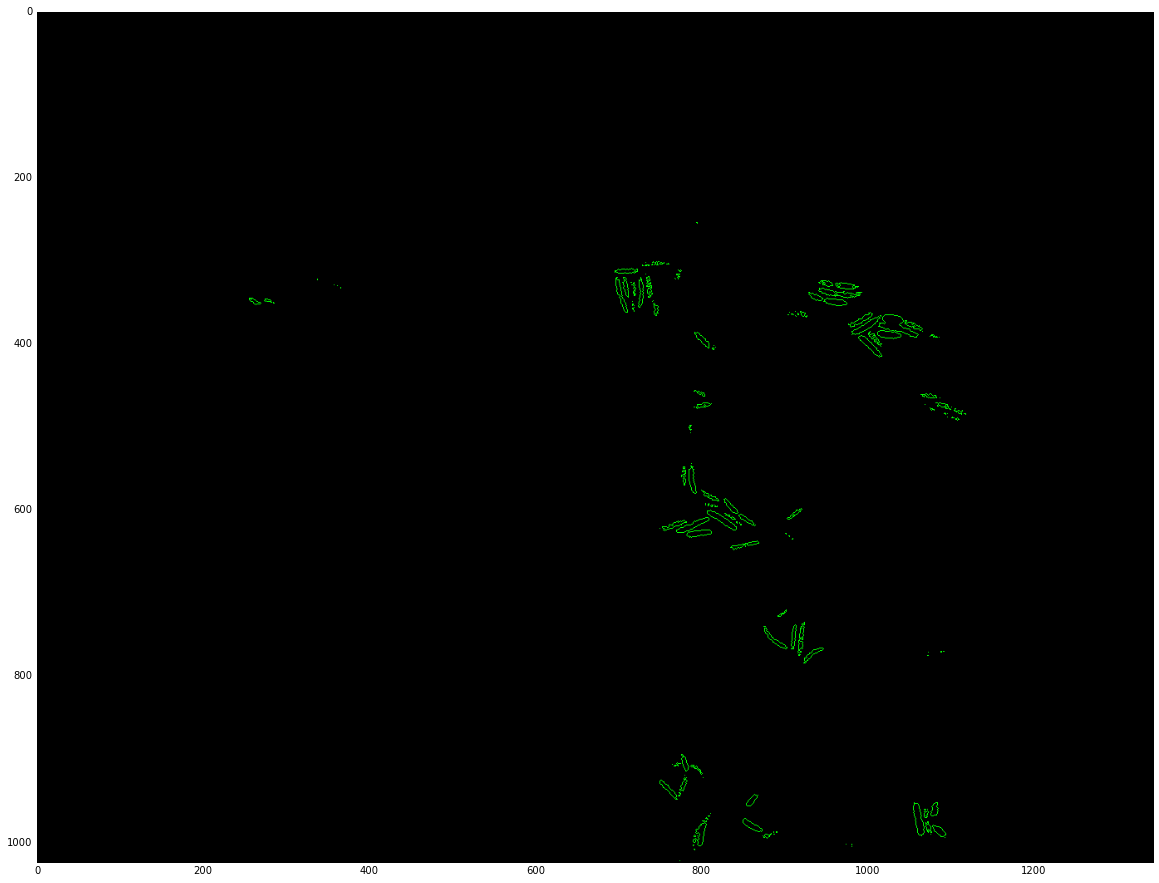

In [10]:
showsegmentation(1,onlysegmentation= True)

# Data Analysis

In [11]:
import pandas as pd
import seaborn as sns

In [12]:
df = pd.read_csv('AllCellData.csv')

In [13]:
df.head(n=5)

,Frame,Time(min),Length(um),Area(um**2),Width(um),L/W,MeanRFP
0,0,0,0.552857,0.356593,1.474286,2.666667,134.263158
1,0,0,1.474286,1.630139,3.132857,2.125000,134.263158
2,0,0,3.685714,4.380998,4.238571,1.150000,131.579710
3,0,0,0.184286,0.000000,0.184286,1.000000,131.579710
4,0,0,4.422857,7.895985,8.292857,1.875000,130.715190


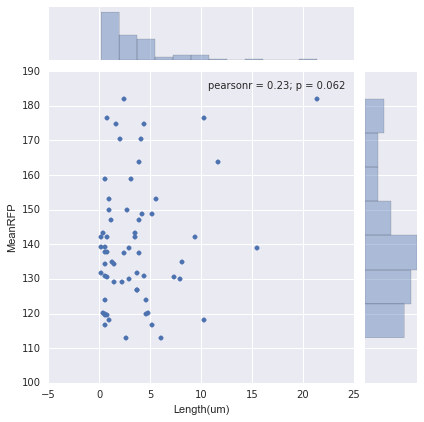

In [14]:
sns.jointplot(x = 'Length(um)', y = 'MeanRFP', data = df.loc[(df.Frame == 0)])

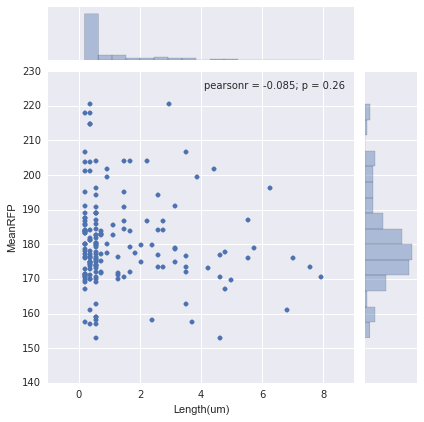

In [15]:
sns.jointplot(x = 'Length(um)', y = 'MeanRFP', data = df.loc[(df.Frame == 1)])

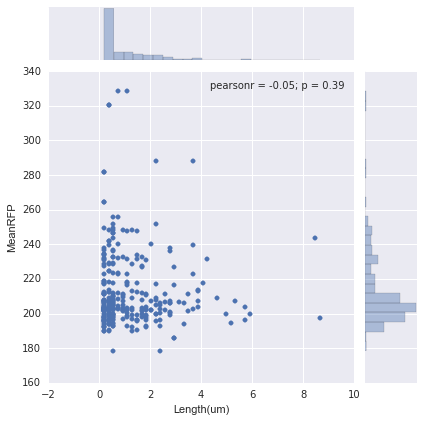

In [16]:
sns.jointplot(x = 'Length(um)', y = 'MeanRFP', data = df.loc[(df.Frame == 2)])